In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import torch

<font color = 'darkblue'>
    
### Problem 1
    
**Ignoring more sophisticated algorithms, like the Strassen algorithm,
multiplying an a × b matrix by a b × c matrix takes O(abc). Please work out the time
complexity of computing a naive K-Fold Cross Validation Ridge Regression on an
N × F input matrix.**

### Answer

$$
\beta_{ridge}=(X^TX+\lambda I)^{-1}X^Ty
$$

to calculate $X^TX$, it costs $O(F^2N)$

to calculate $X^TX+\lambda I$, the adding costs $O(F)$

to calculate $(X^TX+\lambda I)^{-1}$, the inversion costs $O(F^3)$

to calculate $X^Ty$, it costs $O(FN)$

to calculate $[(X^TX+\lambda I)^{-1}](X^Ty)$, it costs $O(F^2)$

In big O notation, we only count dominant term. N must be bigger than F, otherwise the first part connot be invertible, So $O(F^2N)$ dominates $O(F^3)$.

So ridge's cost should be $O(F^2N)$. And here we also do K-Fold Cross Validation, so the cost should time K.

So the final cost is $O(F^2NK)$

To be strict, we should multiply this result with $\frac{k-1}{k}$, as each training we only use this portion of data and use the rest to do the validation.

<font color = 'darkblue'>

### Problem 2
    
**We can be more efficient. We don’t have to compute $(XX^T )^{ −1}$
completely each time. In particular, if you break up X into K chunks, there is a faster
way.**

$$
X=[X_1,X_2,\dots,X_k]^T
$$

**Define $X_{−i}$ as X with the ith fold omitted. Given these hints, write a description
of how you can efficiently compute $X_{ −i}^TX_{ −i}$ for all K folds.**

### Answer

$$
X^TX=\sum_{i=1}^k X_i^TX_i
$$

where $X_i$ has size $n_1\times F$, and $\sum_{i=1}^k n_i=N$

And 
$$
X_{-i}^TX_{-i}=\sum_{j=1,j\ne i}^k X_j^TX_j
$$

So we can fist calculate each $X_{i}^TX_{i}$ and store the results, and sum them up to get $X^TX$. Each time when we want to calculate $X_{-i}^TX_{-i}$, we use 
$$
X_{-i}^TX_{-i}=X^TX-X_{i}^TX_{i}
$$

to do the calculation. So we can save a lot of time without repeatedly calculating matrix multiplying, but do adding and subtraction. Thus the complexity of this algorithm is $O(F^2N)$, because for each $X_i^TX_i$, we need $O(F^2\frac{N}{K})$, and we do it for $K$ times. As for matrix adding and subtraction, complexity is $O(F^2)$, which is dominated by $O(F^2N)$. 

So the time complexity of this algorithm is $O(F^2N)$, much quicker than problem 1.

<font color = 'darkblue'>

#### Data Generating

In [2]:
def generate_test_data_set1(n, f, sigma, test_sample=False):
    np.random.seed(0)
    true_betas = np.random.randn(f)

    np.random.seed(1 if test_sample else 2)
    X = np.random.randn(n, f)
    Y = np.random.randn(n) * sigma + X.dot(true_betas)

    return (X, Y)


def generate_test_data_set2(n, f, sigma, test_sample=False):
    np.random.seed(0)
    true_betas = np.random.randn(f)
    true_betas[-f // 2:] = 0

    np.random.seed(1 if test_sample else 2)
    X = np.random.randn(n, f)
    Y = np.random.randn(n) * sigma + X.dot(true_betas)

    return (X, Y)

In [3]:
#generate 4 data sets and corresponding 4 test sets

data_set11=generate_test_data_set1(10000,5,1)
data_set21=generate_test_data_set2(10000,5,1)
test_set11=generate_test_data_set1(10000,5,1,True)
test_set21=generate_test_data_set2(10000,5,1,True)

data_set12=generate_test_data_set1(10000,20,100)
data_set22=generate_test_data_set2(10000,20,100)
test_set12=generate_test_data_set1(10000,20,100,True)
test_set22=generate_test_data_set2(10000,20,100,True)

<font color = 'darkblue'>

### Problem 3
    
**Use sklearn’s implementation of RidgeCV and LassoCV to fit data
set 1 and 2 from above on 10,000 rows. If you run a simple LassoCV fit with the default
parameters, it will try different values of α, which is their version of a regularization
parameter. After it fits, you can see the alpha values it tried (x.alphas ) as well as the
value of α that it chose (x.alpha ). Plot the out-of-sample error by generating a new
test data set, also of size 10,000, for various values of α. Which data set leads a higher
optimal value of α? Why?**

In [4]:
alphas=[]
i=1e-6
while i<=1e8:
    alphas.append(i)
    i*=10

In [5]:
def ridge_lasso_cv(data_set,alphas=alphas):
    ridgeCV = RidgeCV(alphas).fit(data_set[0],data_set[1])
    lassoCV = LassoCV(alphas=alphas,cv=5).fit(data_set[0],data_set[1])

    print("alphas: ",alphas)
    print("Ridge CV:","\n  chosen alpha: ",ridgeCV.alpha_)
    print("Lasso CV:","\n  chosen alpha: ",lassoCV.alpha_)
    
    return (lassoCV.alpha_,ridgeCV.alpha_)

In Ridge, we use leave one out cross validation

In Lasso, we use 5-fold corss validation

In [6]:
def error_plot(data_set,test_set,lasso_cv_alpha,ridge_cv_alpha,title=None):
    mse_ridge_test=[]
    mse_lasso_test=[]
    mse_ridge_train=[]
    mse_lasso_train=[]
    lasso_in_err,lasso_out_err,ridge_in_err,ridge_out_err = 0,0,0,0
    
    for alpha in alphas:
        ridge=Ridge(alpha=alpha).fit(data_set[0],data_set[1])
        mse_ridge_train.append(mean_squared_error(data_set[1],ridge.predict(data_set[0])))
        mse_ridge_test.append(mean_squared_error(test_set[1],ridge.predict(test_set[0])))

        lasso=Lasso(alpha=alpha).fit(data_set[0],data_set[1])
        mse_lasso_train.append(mean_squared_error(data_set[1],lasso.predict(data_set[0])))
        mse_lasso_test.append(mean_squared_error(test_set[1],lasso.predict(test_set[0])))
        
        if alpha==lasso_cv_alpha:
            lasso_in_err,lasso_out_err = mse_lasso_train[-1], mse_lasso_test[-1]
        if alpha==ridge_cv_alpha:
            ridge_in_err,ridge_out_err = mse_ridge_train[-1], mse_ridge_test[-1]
            

    lg_alphas=[np.log10(alpha) for alpha in alphas]

    plt.figure(figsize=(14,7))
    plt.plot(lg_alphas,mse_ridge_train,"b+--",label="ridge in-sample")
    plt.plot(lg_alphas,mse_lasso_train,"r+--",label="lasso in-sample")
    plt.plot(lg_alphas,mse_ridge_test,'bo--',label="ridge out-of-sample")
    plt.plot(lg_alphas,mse_lasso_test,"ro--",label="lasso out-of-sample")
    plt.xlabel("lg(alpha)")
    plt.ylabel("mse")
    plt.title(title)
    plt.legend()
    plt.show()
    
    return (lasso_in_err,lasso_out_err,ridge_in_err,ridge_out_err)

#### Data Set I with parameter I

In [7]:
alpha11_lasso,alpha11_ridge = ridge_lasso_cv(data_set11)

alphas:  [1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0]
Ridge CV: 
  chosen alpha:  0.1
Lasso CV: 
  chosen alpha:  1e-06


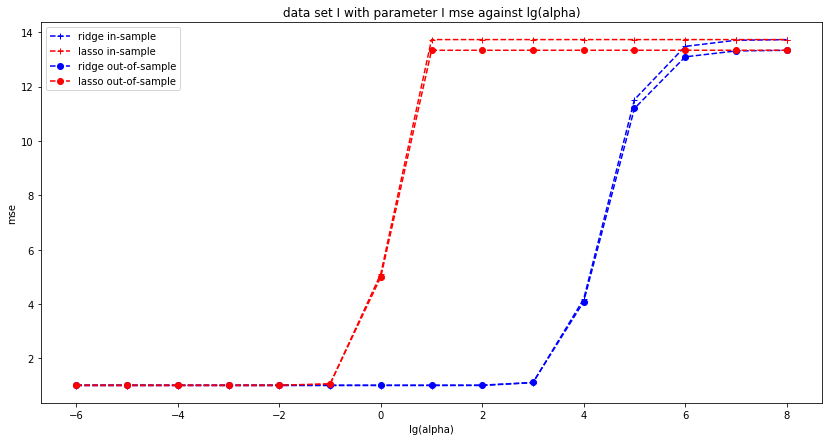

In [8]:
err11_lasso_in,err11_lasso_out,err11_ridge_in,err11_ridge_out = error_plot(
    data_set11,test_set11,alpha11_lasso,alpha11_ridge, "data set I with parameter I mse against lg(alpha)")

#### Data Set I with parameter II

In [9]:
alpha12_lasso,alpha12_ridge = ridge_lasso_cv(data_set12)

alphas:  [1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0]
Ridge CV: 
  chosen alpha:  10000.0
Lasso CV: 
  chosen alpha:  1.0


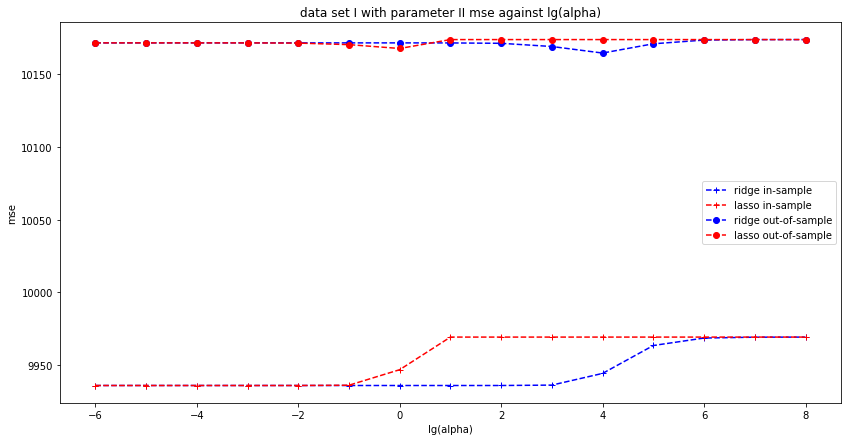

In [10]:
err12_lasso_in,err12_lasso_out,err12_ridge_in,err12_ridge_out = error_plot(
    data_set12,test_set12,alpha12_lasso,alpha12_ridge, "data set I with parameter II mse against lg(alpha)")

#### Data Set II with parameter I

In [11]:
alpha21_lasso,alpha21_ridge = ridge_lasso_cv(data_set21)

alphas:  [1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0]
Ridge CV: 
  chosen alpha:  1.0
Lasso CV: 
  chosen alpha:  0.001


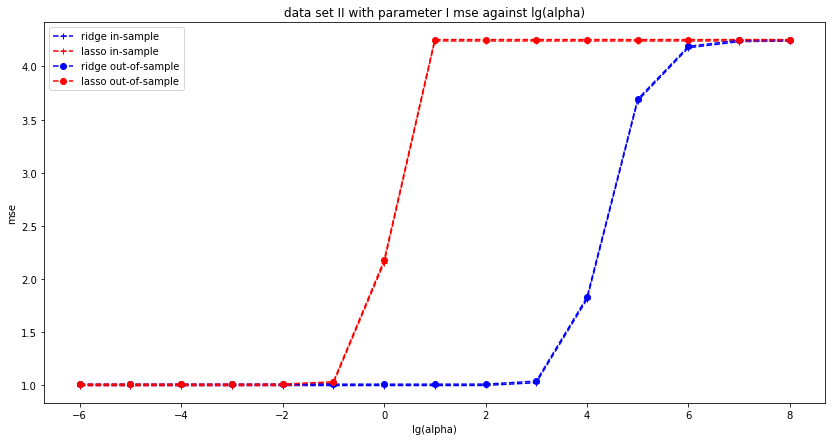

In [12]:
err21_lasso_in,err21_lasso_out,err21_ridge_in,err21_ridge_out = error_plot(
    data_set21,test_set21,alpha21_lasso,alpha21_ridge, "data set II with parameter I mse against lg(alpha)")

In-sample error and out-of-sample error plots are overlapped.

#### Data Set II with parameter II

In [13]:
alpha22_lasso,alpha22_ridge = ridge_lasso_cv(data_set22)

alphas:  [1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0]
Ridge CV: 
  chosen alpha:  100000000.0
Lasso CV: 
  chosen alpha:  100000000.0


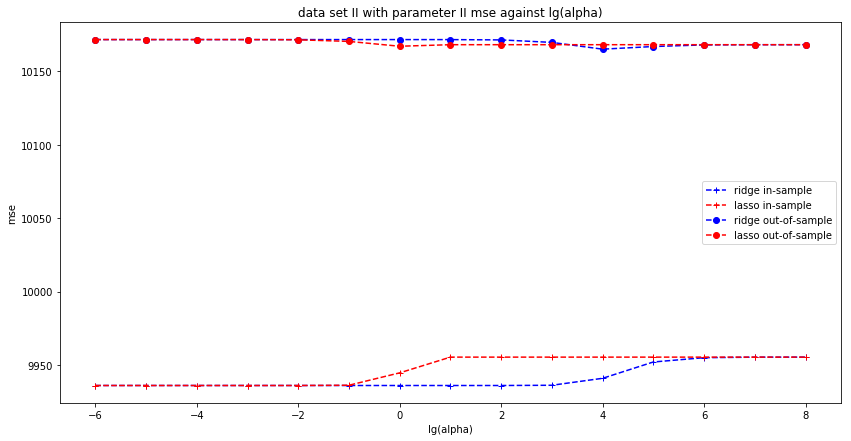

In [14]:
err22_lasso_in,err22_lasso_out,err22_ridge_in,err22_ridge_out = error_plot(
    data_set22,test_set22,alpha22_lasso,alpha22_ridge, "data set II with parameter II mse against lg(alpha)")

In [15]:
comparison={'redundant beta':['False','False','True','True'],
     'f':[5,20,5,20],
     'sigma':[1,100,1,100],
     'lasso cv alpha':[alpha11_lasso,alpha12_lasso,alpha21_lasso,alpha22_lasso],
     'lasso in-sample err':[err11_lasso_in,err12_lasso_in,err21_lasso_in,err22_lasso_in],
     'lasso out-of-ample err':[err11_lasso_out,err12_lasso_out,err21_lasso_out,err22_lasso_out],
     'ridge cv alpha':[alpha11_ridge,alpha12_ridge,alpha21_ridge,alpha22_ridge],
     'ridge in-sample err':[err11_ridge_in,err12_ridge_in,err21_ridge_in,err22_ridge_in],
     'ridge out-of-ample err':[err11_ridge_out,err12_ridge_out,err21_ridge_out,err22_ridge_out]}
comparison=pd.DataFrame(comparison)

In [16]:
comparison

,redundant beta,f,sigma,lasso cv alpha,lasso in-sample err,lasso out-of-ample err,ridge cv alpha,ridge in-sample err,ridge out-of-ample err
0,False,5,1,1.000000e-06,0.997691,1.010031,0.1,0.997691,1.010030
1,False,20,100,1.000000e+00,9946.885342,10167.840990,10000.0,9944.333680,10164.693756
2,True,5,1,1.000000e-03,0.997695,1.010077,1.0,0.997691,1.010033
3,True,20,100,1.000000e+08,9955.339280,10168.207859,100000000.0,9955.335464,10168.206320


Greater f means more features, which leads to higher alpha value. This makes sense because we need to penalize more to avoid over-fitting, since we have more data. Greater sigma leads to very large both in-sample and out-of-sample error, this is consistent with definition of mse. 

Redundant betas leads to greater alpha, as we need to shrink more or drop the redundant features by greater penalty.

Lasso and ridge under best cross validation alpha performs equally well, we can see for same data set, their error are almost same.



<font color='darkblue' >
    
### Problem 4

Implement a simple 1 hidden layer neural network in PyTorch. Let’s
use tanh as our activation function and a hidden layer of 10 neurons. Use this to fit
the 2 data sets from Problem 3. Sample code to start you off is below. Talk about:

• Using the same test data sets as before, calculate the in-sample and out-of-sample
error for the network.

• How does this compare to the error from the RidgeCV and LassoCV fits above?

• Just for the 1st data set, roughly how many epochs did it take to converge?

• Just for the 1st data set, roughly how many epochs does it take to converge if we
change the activation function to ReLu?

#### 1)

In [17]:
def NN_model(F,H,data_set,test_set,epoch=100,is_ReLu=False):
    # model initialize
    out_size=1
    torch.manual_seed(1)
    
    x=torch.tensor(data_set[0],dtype=torch.float32)
    y=torch.tensor(data_set[1][:,np.newaxis],dtype=torch.float32)

    model=torch.nn.Sequential(
        torch.nn.Linear(F,H),
        torch.nn.Tanh() if not is_ReLu else torch.nn.ReLU(),
        torch.nn.Linear(H,out_size),
        )

    loss_fn=torch.nn.MSELoss()
    
    learning_rate=5e-2
    optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
    
    # training  
    loss_history=[]

    for t in range(epoch):
        y_pred=model(x)

        loss=loss_fn(y_pred,y)
        #print(t,loss.item())
        loss_history.append(loss.item())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    plt.figure(figsize=(14,7))
    plt.plot(range(len(loss_history)),loss_history)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
    
    # test
    x_test=torch.tensor(test_set[0],dtype=torch.float32)
    y_test=torch.tensor(test_set[1][:,np.newaxis],dtype=torch.float32)

    err_in=loss_fn(model(x),y).item()
    err_out=loss_fn(model(x_test),y_test).item()

    print("in-sample error: ",err_in,"\n")
    print("out-of-sample error: ",err_out)
    
    return (loss_history,err_in,err_out)

#### Data Set I with parameter I

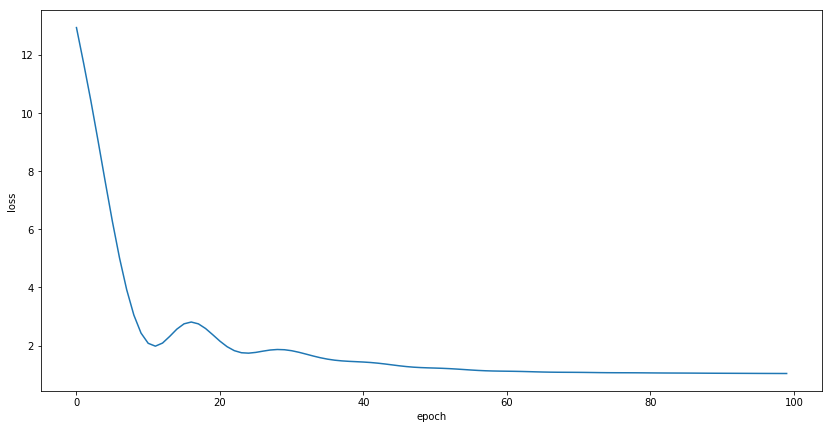

in-sample error:  1.0389487743377686 

out-of-sample error:  1.062627911567688


In [18]:
loss11_history,err11_nn_in,err11_nn_out=NN_model(5,10,data_set11,test_set11)

#### Data Set I with parameter II

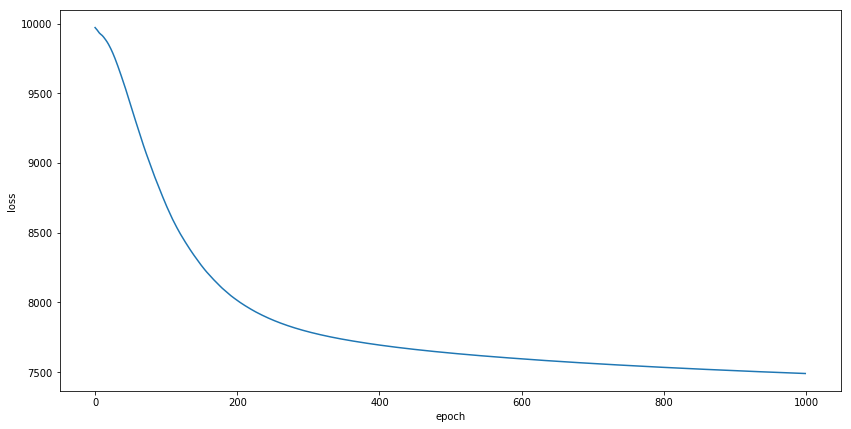

in-sample error:  7490.26611328125 

out-of-sample error:  12400.5537109375


In [19]:
loss12_history,err12_nn_in,err12_nn_out=NN_model(20,40,data_set12,test_set12,epoch=1000)

#### Data Set II with parameter I

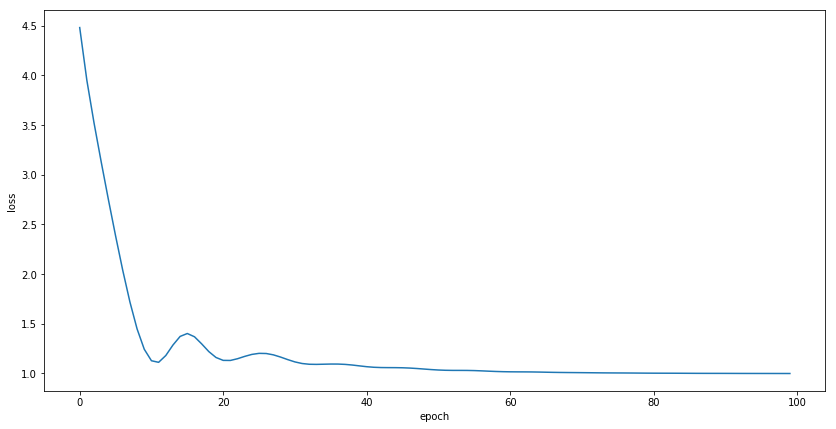

in-sample error:  0.9991199970245361 

out-of-sample error:  1.016243577003479


In [20]:
loss21_history,err21_nn_in,err21_nn_out=NN_model(5,10,data_set21,test_set21)

#### Data Set II with parameter II

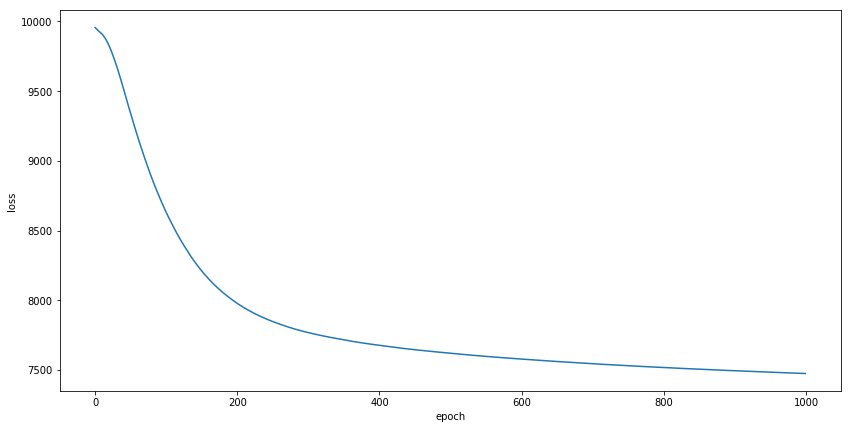

in-sample error:  7474.736328125 

out-of-sample error:  12461.8173828125


In [21]:
loss22_history,err22_nn_in,err22_nn_out=NN_model(20,40,data_set22,test_set22,epoch=1000)

#### 2)

We compare Ridge and Lasso results under best cross-validation alpha with neutral network.

In [22]:
print("data set I with parameter I:")
print("  Lasso:")
print("    train: ",err11_lasso_in)
print("    test:  ",err11_lasso_out)
print("  Ridge:")
print("    train: ",err11_ridge_in)
print("    test:  ",err11_ridge_out)
print("  Neutral Network:")
print("    train: ",err11_nn_in)
print("    test:  ",err11_nn_out)

print("\ndata set I with parameter II:")
print("  Lasso:")
print("    train: ",err12_lasso_in)
print("    test:  ",err12_lasso_out)
print("  Ridge:")
print("    train: ",err12_ridge_in)
print("    test:  ",err12_ridge_out)
print("  Neutral Network:")
print("    train: ",err12_nn_in)
print("    test:  ",err12_nn_out)

print("\ndata set II with parameter I:")
print("  Lasso:")
print("    train: ",err21_lasso_in)
print("    test:  ",err21_lasso_out)
print("  Ridge:")
print("    train: ",err21_ridge_in)
print("    test:  ",err21_ridge_out)
print("  Neutral Network:")
print("    train: ",err21_nn_in)
print("    test:  ",err21_nn_out)

print("\ndata set II with parameter II:")
print("  Lasso:")
print("    train: ",err22_lasso_in)
print("    test:  ",err22_lasso_out)
print("  Ridge:")
print("    train: ",err22_ridge_in)
print("    test:  ",err22_ridge_out)
print("  Neutral Network:")
print("    train: ",err22_nn_in)
print("    test:  ",err22_nn_out)

data set I with parameter I:
  Lasso:
    train:  0.9976911151951062
    test:   1.0100305858523435
  Ridge:
    train:  0.997691116466355
    test:   1.010030288962445
  Neutral Network:
    train:  1.0389487743377686
    test:   1.062627911567688

data set I with parameter II:
  Lasso:
    train:  9946.885342292077
    test:   10167.840989737377
  Ridge:
    train:  9944.33367959123
    test:   10164.693756090375
  Neutral Network:
    train:  7490.26611328125
    test:   12400.5537109375

data set II with parameter I:
  Lasso:
    train:  0.9976954062887348
    test:   1.0100769985242344
  Ridge:
    train:  0.9976911476552519
    test:   1.010033461678113
  Neutral Network:
    train:  0.9991199970245361
    test:   1.016243577003479

data set II with parameter II:
  Lasso:
    train:  9955.339279508502
    test:   10168.207859223168
  Ridge:
    train:  9955.33546436624
    test:   10168.20632008298
  Neutral Network:
    train:  7474.736328125
    test:   12461.8173828125


For two data sets with parameter I, with only 100 epochs, the NN's performance seems a little worse than Ridge and Lasso. This is due to the limitation of epoch number. With more epochs, the error from NN should be smaller or at least equal than linear models.

For two data sets with parameter II, even run 1000 epochs, the error is relative large. This is due to the big sigma of data generating parameters. And NN's in-sample error is smaller than linear model while the out-of-sample is larger. This reflects NN is prone to over-fitting.

#### 3)

Because the parameter II makes the model very hard to converge. We can see the in-sample error was still 7000+ even after 1000 epochs. So here we only discuss data set I with parameter I.

Zoom in the figure of loss history of data set I with parameter I during the training.

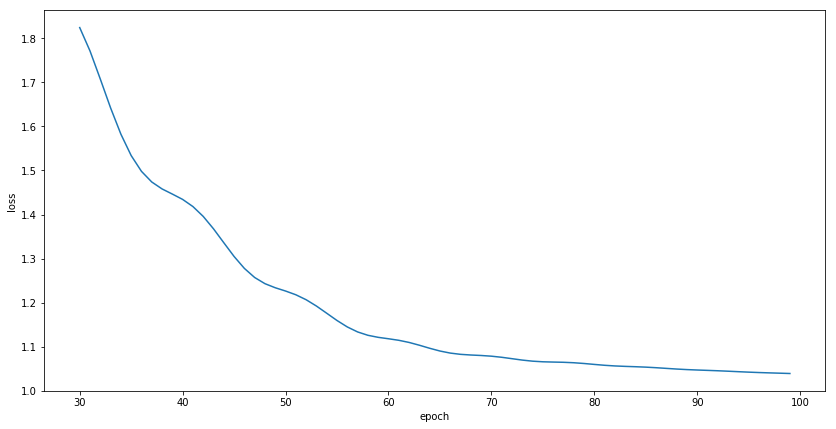

In [23]:
plt.figure(figsize=(14,7))
plt.plot(range(len(loss11_history))[30:],loss11_history[30:])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

It seems that after 80 epochs, it converges. 

In order to decide precisely after how many epochs, the model converges, we need a quantitative criterion. Here we define if the improvement of mse in one epoch is smaller than 1e-3, than we say model converges.

In [24]:
for i in range(1,100):
    if loss11_history[i-1]>loss11_history[i] and loss11_history[i-1]-loss11_history[i]<1e-3:
        print("Tanh activation converges after",i,"epochs")
        break

Tanh activation converges after 76 epochs


#### 4)

Here we change activation function to ReLu

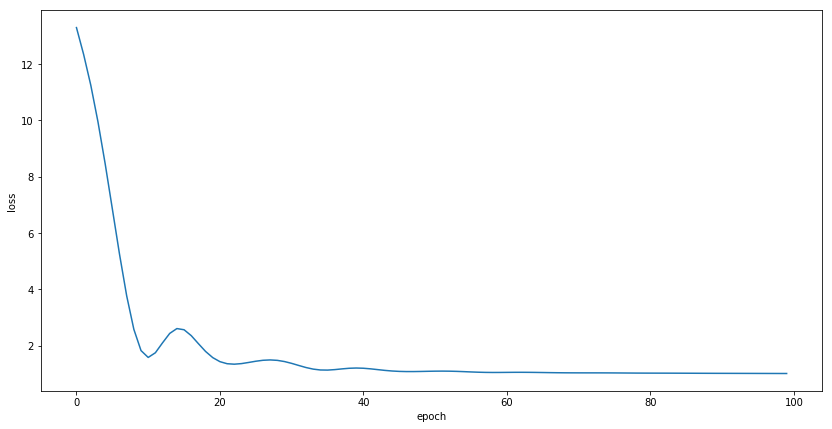

in-sample error:  1.0168170928955078 

out-of-sample error:  1.0350059270858765


In [25]:
loss11_relu_history,err11_nn_relu_in,err11_nn_relu_out=NN_model(5,10,data_set11,test_set11,is_ReLu=True)

Zoom in the last figure

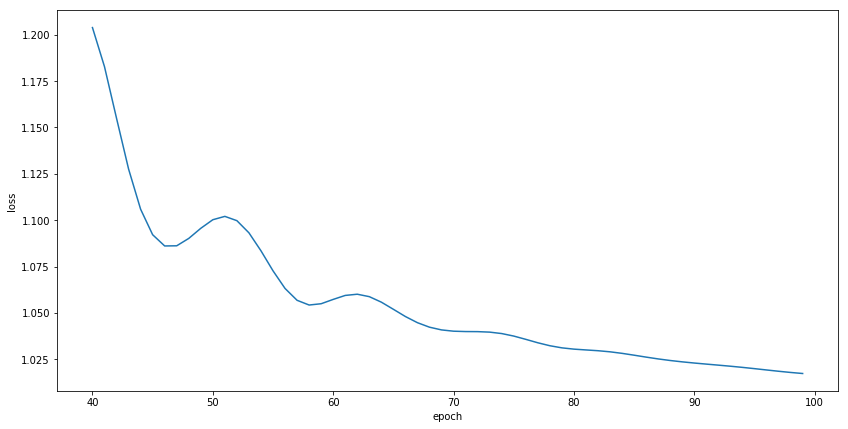

In [26]:
plt.figure(figsize=(14,7))
plt.plot(range(len(loss11_relu_history))[40:],loss11_relu_history[40:])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

From in-sample and out-of-sample error, we see ReLU converges faster than Tanh. Apply same quantitaive criterion for convergence, if the improvement of mse in one epoch is smaller than 1e-3, than we say model converges.

In [27]:
for i in range(1,100):
    if loss11_relu_history[i-1]>loss11_relu_history[i] and loss11_relu_history[i-1]-loss11_relu_history[i]<1e-3:
        print("ReLU activation converges after",i,"epochs")
        break

ReLU activation converges after 70 epochs


We can conclude in this data set, ReLU activation converges faster than Tanh activation.

In [1]:
#pip freeze

alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==1.9.7
anaconda-project==0.8.2
appdirs==1.4.3
asn1crypto==0.24.0
asteval==0.9.13
astroid==2.2.5
astropy==3.1.2
atomicwrites==1.3.0
attrs==19.1.0
Automat==0.7.0
autopep8==1.4.3
Babel==2.6.0
backcall==0.1.0
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.7.1
bitarray==0.8.3
bkcharts==0.2
blaze==0.11.3
bleach==3.1.0
bokeh==1.0.4
boto==2.49.0
Bottleneck==1.2.1
certifi==2019.3.9
cffi==1.12.2
chardet==3.0.4
Click==7.0
cloudpickle==0.8.0
clyent==1.2.2
colorama==0.4.1
conda==4.6.11
conda-build==3.17.8
constantly==15.1.0
contextlib2==0.5.5
cryptography==2.6.1
cycler==0.10.0
Cython==0.29.6
cytoolz==0.9.0.1
dask==1.1.4
datashape==0.5.4
decorator==4.4.0
defusedxml==0.5.0
distributed==1.26.0
docutils==0.14
entrypoints==0.3
et-xmlfile==1.0.1
fastcache==1.0.2
filelock==3.0.10
Flask==1.0.2
Flask-Cors==3.0.7
gevent==1.4.0
glob2==0.6
gmpy2==2.0.8
greenlet==0.4.15
h5py==2.9.0
heapdict==1.0.0
html5lib==1.0.1
hyperl